In [2]:
import pandas as pd
import numpy as np
import cveig
import networkx as nx
from scipy.sparse import dok_array
import matplotlib.pyplot as plt

In [3]:
emails = pd.read_table('data/email-Eu-core.txt', names=['source', 'target'], sep=' ')

In [4]:
emails

,source,target
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7
...,...,...
25566,420,143
25567,174,859
25568,440,460
25569,52,786


In [5]:
departments = pd.read_table('data/email-Eu-core-department-labels.txt', names=['node', 'department'], sep=' ')

In [6]:
departments

,node,department
0,0,1
1,1,1
2,2,21
3,3,21
4,4,21
...,...,...
1000,1000,4
1001,1001,21
1002,1002,1
1003,1003,6


In [7]:
dept_sizes = departments.groupby('department').size()

In [8]:
small_depts = dept_sizes[dept_sizes < 10]

In [9]:
nodes_to_ignore = departments[departments.department.isin(small_depts.keys())]

In [10]:
nodes_to_ignore

,node,department
5,5,25
6,6,25
13,13,26
64,64,25
80,80,29
...,...,...
941,941,41
966,966,29
971,971,32
980,980,12


In [11]:
emails_filtered = emails[~emails.source.isin(nodes_to_ignore.node) & ~emails.target.isin(nodes_to_ignore.node)]

In [12]:
emails_filtered.shape

(22028, 2)

In [13]:
email_graph = nx.from_pandas_edgelist(emails_filtered, create_using=nx.DiGraph)

In [14]:
adjacency_matrix = nx.to_numpy_matrix(email_graph)

In [15]:
adjacency_matrix.shape

(929, 929)

In [16]:
ground_truth = 28

In [17]:
small_depts.keys()

Int64Index([12, 18, 24, 25, 26, 28, 29, 30, 31, 32, 33, 39, 40, 41], dtype='int64', name='department')

In [18]:
sparse_matrix = dok_array(adjacency_matrix.astype(np.int32))
nb = cveig.non_backtracking(sparse_matrix, 35)
bh = cveig.bethe_hessian(sparse_matrix)
cv = cveig.eig_cv(sparse_matrix, 35, 0.1)
cv_mod = cveig.eig_cv_mod(sparse_matrix, 35, 0.1)

In [19]:
print(nb, bh, cv, cv_mod)

6 17 21 1


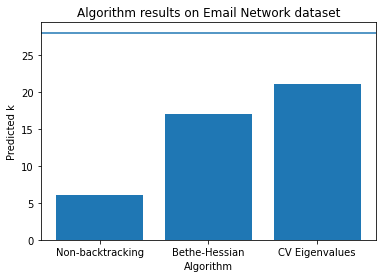

In [25]:
plt.bar(['Non-backtracking', 'Bethe-Hessian', 'CV Eigenvalues'],[nb, bh, cv])
plt.axhline(28)
plt.xlabel('Algorithm')
plt.ylabel('Predicted k')
plt.title('Algorithm results on Email Network dataset')
plt.savefig('email.png')

In [26]:
email_graph_bern = nx.from_pandas_edgelist(emails_filtered, create_using=nx.Graph)

In [27]:
adjacency_matrix_bern = nx.to_numpy_matrix(email_graph_bern)

In [28]:
sparse_matrix_bern = dok_array(adjacency_matrix_bern.astype(np.int32))
nb_bern = cveig.non_backtracking(sparse_matrix_bern, 35)
bh_bern = cveig.bethe_hessian(sparse_matrix_bern)
cv_bern = cveig.eig_cv(sparse_matrix_bern, 35, 0.1)

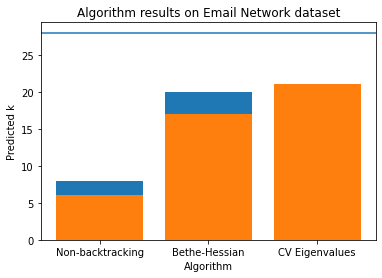

In [30]:
plt.bar(['Non-backtracking', 'Bethe-Hessian', 'CV Eigenvalues'],[nb_bern, bh_bern, cv_bern], label='Without multiple edges')
plt.bar(['Non-backtracking', 'Bethe-Hessian', 'CV Eigenvalues'],[nb, bh, cv], label='With multiple edges')
plt.axhline(28)
plt.xlabel('Algorithm')
plt.ylabel('Predicted k')
plt.title('Algorithm results on Email Network dataset')
plt.savefig('email_bern.png')

In [40]:
df1 = pd.DataFrame({'algorithm': ['Non-backtracking', 'Bethe-Hessian', 'CV Eigenvalues'], 'predicted k': [nb, bh, cv], 'multigraph': True})
df2 = pd.DataFrame({'algorithm': ['Non-backtracking', 'Bethe-Hessian', 'CV Eigenvalues'], 'predicted k': [nb_bern, bh_bern, cv_bern], 'multigraph': False})
df = pd.concat([df1, df2])

In [36]:
import seaborn as sns

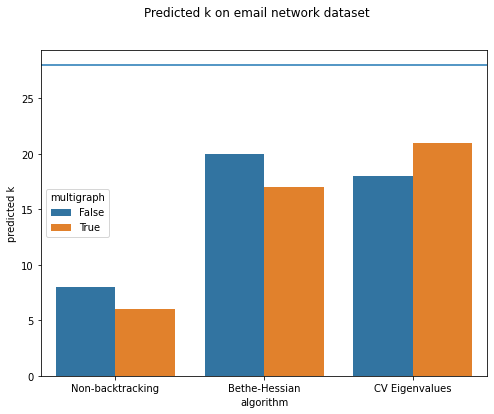

In [50]:
fig, ax= plt.subplots(1, figsize=(8,6))
sns.barplot(data=df, x='algorithm', y='predicted k', hue='multigraph', ax=ax)
ax.axhline(28)
fig.suptitle('Predicted k on email network dataset')
fig.savefig('email_both.png')